In [1]:
from typing import Dict,Callable

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim,Tensor,unsqueeze
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.autograd
import torch.nn as nn
from torchvision.models.resnet import resnet50,resnet18
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
import torch.nn.functional as F

from mydataset import MyTrainDataset, my_dataset_worker_init_func

from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, write_gt_csv, read_gt_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace, average_displacement_error_mean, final_displacement_error_mean
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

D:\Anaconda3\envs\lgsvl\lib\site-packages\l5kit\dataset\select_agents.py:32: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


# 数据处理

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "E:/Downloads/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'CVAE', 'latent_dim': 128, 'num_layers': 2, 'bidirectional': False, 'history_step_size': 1, 'history_num_frames': 49, 'future_step_size': 1, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': True, 'num_workers': 2}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': False, 'num_workers': 2}, 'train_params': {'device': 1, 'epochs': 1}}


In [3]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
print(len(train_dataset))
print(train_dataset)
print(train_dataset[0].keys())

train_dataset = MyTrainDataset(cfg, dm, len(train_dataset),raster_mode = 1)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=train_cfg["shuffle"], 
    batch_size=train_cfg["batch_size"],
    num_workers=train_cfg["num_workers"],
    pin_memory = True,
    persistent_workers=True,
    worker_init_fn=my_dataset_worker_init_func
)

111634
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_v

# 参数

In [4]:
# 基本参数
if cfg["train_params"]["device"] == 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
torch.backends.cudnn.benchmark = True
epochs = cfg["train_params"]["epochs"]
latent_dim = cfg["model_params"]["latent_dim"]  # LSTM 的单元个数
num_layers = cfg["model_params"]["num_layers"]
bidirectional = cfg["model_params"]["bidirectional"]
num_classes = 3 # 类数
encoder_length = cfg["model_params"]["history_num_frames"]
decoder_length = cfg["model_params"]["future_num_frames"]
num_encoder_tokens = 2
num_decoder_tokens = 2
z_dimension = 16
accumulation_steps = 3 # 梯度累积步数

In [5]:
def neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)

# 模型

In [6]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        # 定义编码器
        self.encoder = nn.LSTM(
            num_encoder_tokens, latent_dim, num_layers=num_layers, bidirectional=bidirectional,batch_first=True)
        self.encoder2 = nn.Linear(latent_dim*(1+bidirectional), 16)
#         self.encoder_mean1 = nn.Linear(latent_dim*(1+bidirectional), 64)
        self.encoder_mean2 = nn.Linear(16*2, z_dimension)
#         self.encoder_std1 = nn.Linear(latent_dim*(1+bidirectional), 32)
        self.encoder_std2 = nn.Linear(16*2, z_dimension)

        # 定义解码器
        self.decoder = nn.LSTM(z_dimension, latent_dim, num_layers=num_layers,
                               bidirectional=bidirectional,batch_first=True)
        self.decoder_fc = nn.Linear(latent_dim*(1+bidirectional), 64)
        self.decoder_fc1 = nn.Linear(64, num_decoder_tokens)
        self.decoder_fc2 = nn.Linear(64, num_decoder_tokens)
        self.decoder_fc3 = nn.Linear(64, num_decoder_tokens)
        self.decoder_confi = nn.Linear(64, num_classes)

        # 道路特征提取器
        # load pre-trained Conv2D model
        self.resnet = resnet50(pretrained=True)
        # change input channels number to match the rasterizer's output
        num_history_channels = (
            cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels
        self.resnet.conv1 = nn.Conv2d(
            num_in_channels,
            self.resnet.conv1.out_channels,
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=False,
        )
        # change output size to (X, Y) * number of future states
        num_targets = 16 * cfg["model_params"]["future_num_frames"]
        self.resnet.fc = nn.Linear(in_features=2048, out_features=num_targets)

    def noise_reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, data):
        inputs1 = torch.FloatTensor(data["history_positions"]).to(device)
        if inputs1.dim() == 2:
            inputs1.unsqueeze(0)
#             inputs1.resize_(1, inputs1.size()[0], inputs1.size()[1])
#         print(inputs.size())
        h0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)
        c0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)
        inputs2 = torch.FloatTensor(data["image"]).to(device)
        if inputs2.dim() == 3:
            inputs2.unsqueeze(0)
#             inputs2.resize_(1, inputs2.size()[0], inputs2.size()[1], inputs2.size()[2])
        out11, _ = self.encoder(inputs1, (h0, c0))
        out11 = F.relu(self.encoder2(out11), inplace=True)
        out12 = self.resnet(inputs2).reshape(out11.size())
        out1 = torch.cat([out11, out12], 2)
#         print(out1.size())
#         mean1 = F.relu(self.encoder_mean1(out1), inplace=True)
        mean2 = F.relu(self.encoder_mean2(out1), inplace=True)
#         logstd1 = F.relu(self.encoder_std1(out1), inplace=True)
        logstd2 = F.relu(self.encoder_std2(out1), inplace=True)
        z = self.noise_reparameterize(mean2, logstd2)
        out2, _ = self.decoder(z)
        out2 = F.relu(self.decoder_fc(out2), inplace=True)
        
        out21 = F.relu(self.decoder_fc1(out2), inplace=True)
#         out21 = out21.view(out21.size()[0],1,decoder_length,num_decoder_tokens)
        out21 = torch.unsqueeze(out21,1)
        out22 = F.relu(self.decoder_fc2(out2), inplace=True)
        out22 = torch.unsqueeze(out22,1)
#         out22 = out22.view(out22.size()[0],1,decoder_length,num_decoder_tokens)
        out23 = F.relu(self.decoder_fc3(out2), inplace=True)
        out23 = torch.unsqueeze(out23,1)
#         out23 = out23.view(out23.size()[0],1,decoder_length,num_decoder_tokens)
        
        confidences = F.softmax(self.decoder_confi(out2)[:,-1,:])
        y_hat = torch.cat([out21,out22,out23],dim=1)
#         print(confidences)
        return y_hat, confidences, mean2, logstd2


def loss_function(y_hat, confidences, data, mean, std):
    y_availabilities = data["target_availabilities"].to(device)
    y_true = data["target_positions"].to(device)
#     MSE = F.mse_loss(y_hat, y_true, reduction='none')
#     MSE = MSE * y_availabilities
#     MSE = MSE.mean()
    NLL = neg_multi_log_likelihood_batch(y_true, y_hat, confidences, y_availabilities)
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var = torch.pow(torch.exp(std), 2)
    KLD = -0.5 * torch.mean(1+torch.log(var)-torch.pow(mean, 2)-var)
    return NLL + 1000*KLD


# 创建对象
cvae = CVAE().to(device)
# vae.load_state_dict(torch.load('./VAE_z2.pth'))
cvae_optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)

In [7]:
# ==== TRAIN LOOP
losses_avg = []
for epoch in range(epochs):  # 进行多个epoch的训练
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(len(train_dataloader)//1000),position=0)
    losses_train = []
    cvae_optimizer.zero_grad(set_to_none = True)
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        cvae.train() # 设置为训练模式
        torch.set_grad_enabled(True)
        y_hat, confidences, mean, std = cvae(data)  # 输入
        if cfg["train_params"]["device"] == 1:
            with torch.cuda.amp.autocast():
                loss = loss_function(y_hat, confidences, data, mean, std)
        else:
            loss = loss_function(y_hat, confidences, data, mean, std)

        # Backward pass
        # 梯度累积模式
        loss = loss / accumulation_steps
        loss.backward() 
        if (i+1) % accumulation_steps == 0:
            cvae_optimizer.step()
            cvae_optimizer.zero_grad(set_to_none = True)
            
        # 无梯度累积模式
#         cvae_optimizer.zero_grad(set_to_none = True)
#         loss.backward()
#         cvae_optimizer.step()
        losses_train.append(loss.item())
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    losses_avg.append(np.mean(losses_train))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]D:\Anaconda3\envs\lgsvl\lib\site-packages\ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss: 3493.207763671875 loss(avg): 2295.1407368977866: 100%|█████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


# 结果

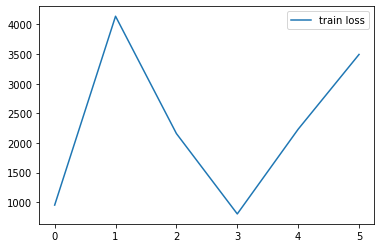

In [8]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

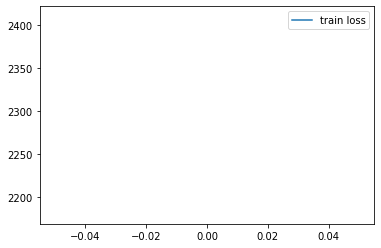

In [9]:
plt.plot(np.arange(len(losses_avg)), losses_avg, label="train loss")
plt.legend()
plt.show()

# 评估

In [10]:
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)
print(len(eval_dataset))
print(eval_dataset)
print(eval_dataset[0].keys())

eval_dataset = MyTrainDataset(cfg, dm, len(eval_dataset),raster_mode = 1)
eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=eval_cfg["shuffle"], 
    batch_size=eval_cfg["batch_size"],
    num_workers=eval_cfg["num_workers"],
    persistent_workers=True,
    worker_init_fn=my_dataset_worker_init_func
)

111634
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_v

## 保存预测

In [ ]:
# ==== EVAL LOOP
cvae.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
gt_coords_offsets_pd = []
timestamps = []
agent_ids = []
availability = []
progress_bar = tqdm(train_dataloader,position=0)

for data in progress_bar:
    y_hat, confidences,_,_ = cvae(data)
#     print(data)
    # convert agent coordinates into world offsets
    confs = confidences.detach().cpu().numpy()
    agents_coords = y_hat.detach().cpu().numpy()
    gt_coords = data['target_positions'].numpy()
    world_from_agents = data['world_from_agent'].numpy()
    centroids = data["centroid"].numpy()
    coords_offset1 = transform_points(agents_coords[:,0,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset2 = transform_points(agents_coords[:,1,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset3 = transform_points(agents_coords[:,2,:,:], world_from_agents) - centroids[:, None, :2]
    coords_offset = np.stack([coords_offset1,coords_offset2,coords_offset3],1)
    gt_offset = transform_points(gt_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    gt_coords_offsets_pd.append(np.stack(gt_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    availability.append(data["target_availabilities"].numpy().copy())
    
pred_path = "/pred.csv"
eval_gt_path = "/gt.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
               confs=np.concatenate(confs)
              )

write_gt_csv(eval_gt_path,timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(gt_coords_offsets_pd),avails=np.concatenate(availability))

 55%|█████████████████████████████████████████▉                                  | 3847/6978 [1:14:43<54:34,  1.05s/it]

## 预测结果

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [
                              neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
    if metric_name=="time_displace":
        FDE = metric_mean
print('FDE1s: {}, FDE3s: {}, FDE5s: {}, ADE1s: {}, ADE3s: {}, ADE5s: {} '.format(
    FDE[9], FDE[29], FDE[49], np.mean(FDE[:10]), np.mean(FDE[:30]), np.mean(FDE[:50])))

In [ ]:
cvae.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]
        out_net,confs = cvae(data_agent)
        confs = confs.detach().cpu().numpy()
        out_net = out_net[0][np.argmax(confs)]
        out_pos = out_net.reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()